In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv

# ==========================================
# 1. PI-ELM Solver Class
# ==========================================
class PI_ELM_Solver:
    def __init__(self, n_neurons, alpha):
        self.N = n_neurons
        self.alpha = alpha

        # Initialize fixed random weights and biases
        # Using a slightly wider range for weights can help capture higher frequencies if needed
        self.w_x = np.random.uniform(-1.5, 1.5, (self.N, 1))
        self.w_t = np.random.uniform(-1.5, 1.5, (self.N, 1))
        self.b = np.random.uniform(-1.5, 1.5, (self.N, 1))

        self.beta = None

    def activation(self, Z, order=0):
        # Tanh activation and derivatives
        if order == 0:
            return np.tanh(Z)
        elif order == 1:
            return 1 - np.tanh(Z)**2
        elif order == 2:
            return -2 * np.tanh(Z) * (1 - np.tanh(Z)**2)
        return np.tanh(Z)

    def build_matrix(self, x, t, type='pde'):
        Z = self.w_x @ x.T + self.w_t @ t.T + self.b

        if type == 'pde':
            # PDE Residual: u_t - alpha * u_xx
            dt_term = self.activation(Z, order=1).T * self.w_t.T
            dxx_term = self.activation(Z, order=2).T * (self.w_x**2).T
            return dt_term - self.alpha * dxx_term

        elif type == 'boundary':
            # Function value: u
            return self.activation(Z, order=0).T

    def train(self, X_f, T_f, X_ic, T_ic, X_lb, T_lb, X_ub, T_ub, u_ic_vals, u_bc_vals):
        # 1. Build Matrices
        H_f = self.build_matrix(X_f, T_f, type='pde')
        H_ic = self.build_matrix(X_ic, T_ic, type='boundary')
        H_lb = self.build_matrix(X_lb, T_lb, type='boundary')
        H_ub = self.build_matrix(X_ub, T_ub, type='boundary')

        # 2. Stack Targets
        # PDE target is 0
        T_target_f = np.zeros((X_f.shape[0], 1))
        T_target_ic = u_ic_vals
        T_target_lb = u_bc_vals['lb']
        T_target_ub = u_bc_vals['ub']

        # 3. Combine Global System
        H_global = np.vstack([H_ic, H_lb, H_ub, H_f])
        T_global = np.vstack([T_target_ic, T_target_lb, T_target_ub, T_target_f])

        print(f"Solving Linear System (Size: {H_global.shape})...")
        self.beta = pinv(H_global) @ T_global
        print("Training complete.")

    def predict(self, x, t):
        Z = self.w_x @ x.T + self.w_t @ t.T + self.b
        return self.activation(Z, order=0).T @ self.beta

# ==========================================
# 2. Problem Definitions
# ==========================================
def exact_solution(x, t, alpha):
    """
    Analytic solution for Heat Equation with:
    u(x,0) = sin(pi*x)
    u(-1,t) = u(1,t) = 0
    Solution: u(x,t) = exp(-alpha * pi^2 * t) * sin(pi * x)
    """
    return np.exp(-alpha * (np.pi**2) * t) * np.sin(np.pi * x)

# Parameters
alpha = 0.05
N_neurons = 500

# Collocation Points
N_f = 5000
x_f = np.random.uniform(-1, 1, (N_f, 1))
t_f = np.random.uniform(0, 1, (N_f, 1))

# IC/BC Points
N_bound = 150
# IC: t=0
x_ic = np.random.uniform(-1, 1, (N_bound, 1))
t_ic = np.zeros((N_bound, 1))
u_ic = np.sin(np.pi * x_ic)

# BC: x=-1 and x=1
t_bc = np.random.uniform(0, 1, (N_bound, 1))
x_lb = -1 * np.ones((N_bound, 1))
x_ub = 1 * np.ones((N_bound, 1))
u_lb = np.zeros((N_bound, 1))
u_ub = np.zeros((N_bound, 1))

# ==========================================
# 3. Training
# ==========================================
model = PI_ELM_Solver(N_neurons, alpha)
model.train(x_f, t_f, x_ic, t_ic, x_lb, t_bc, x_ub, t_bc, u_ic, {'lb': u_lb, 'ub': u_ub})


Solving Linear System (Size: (5450, 500))...
Training complete.


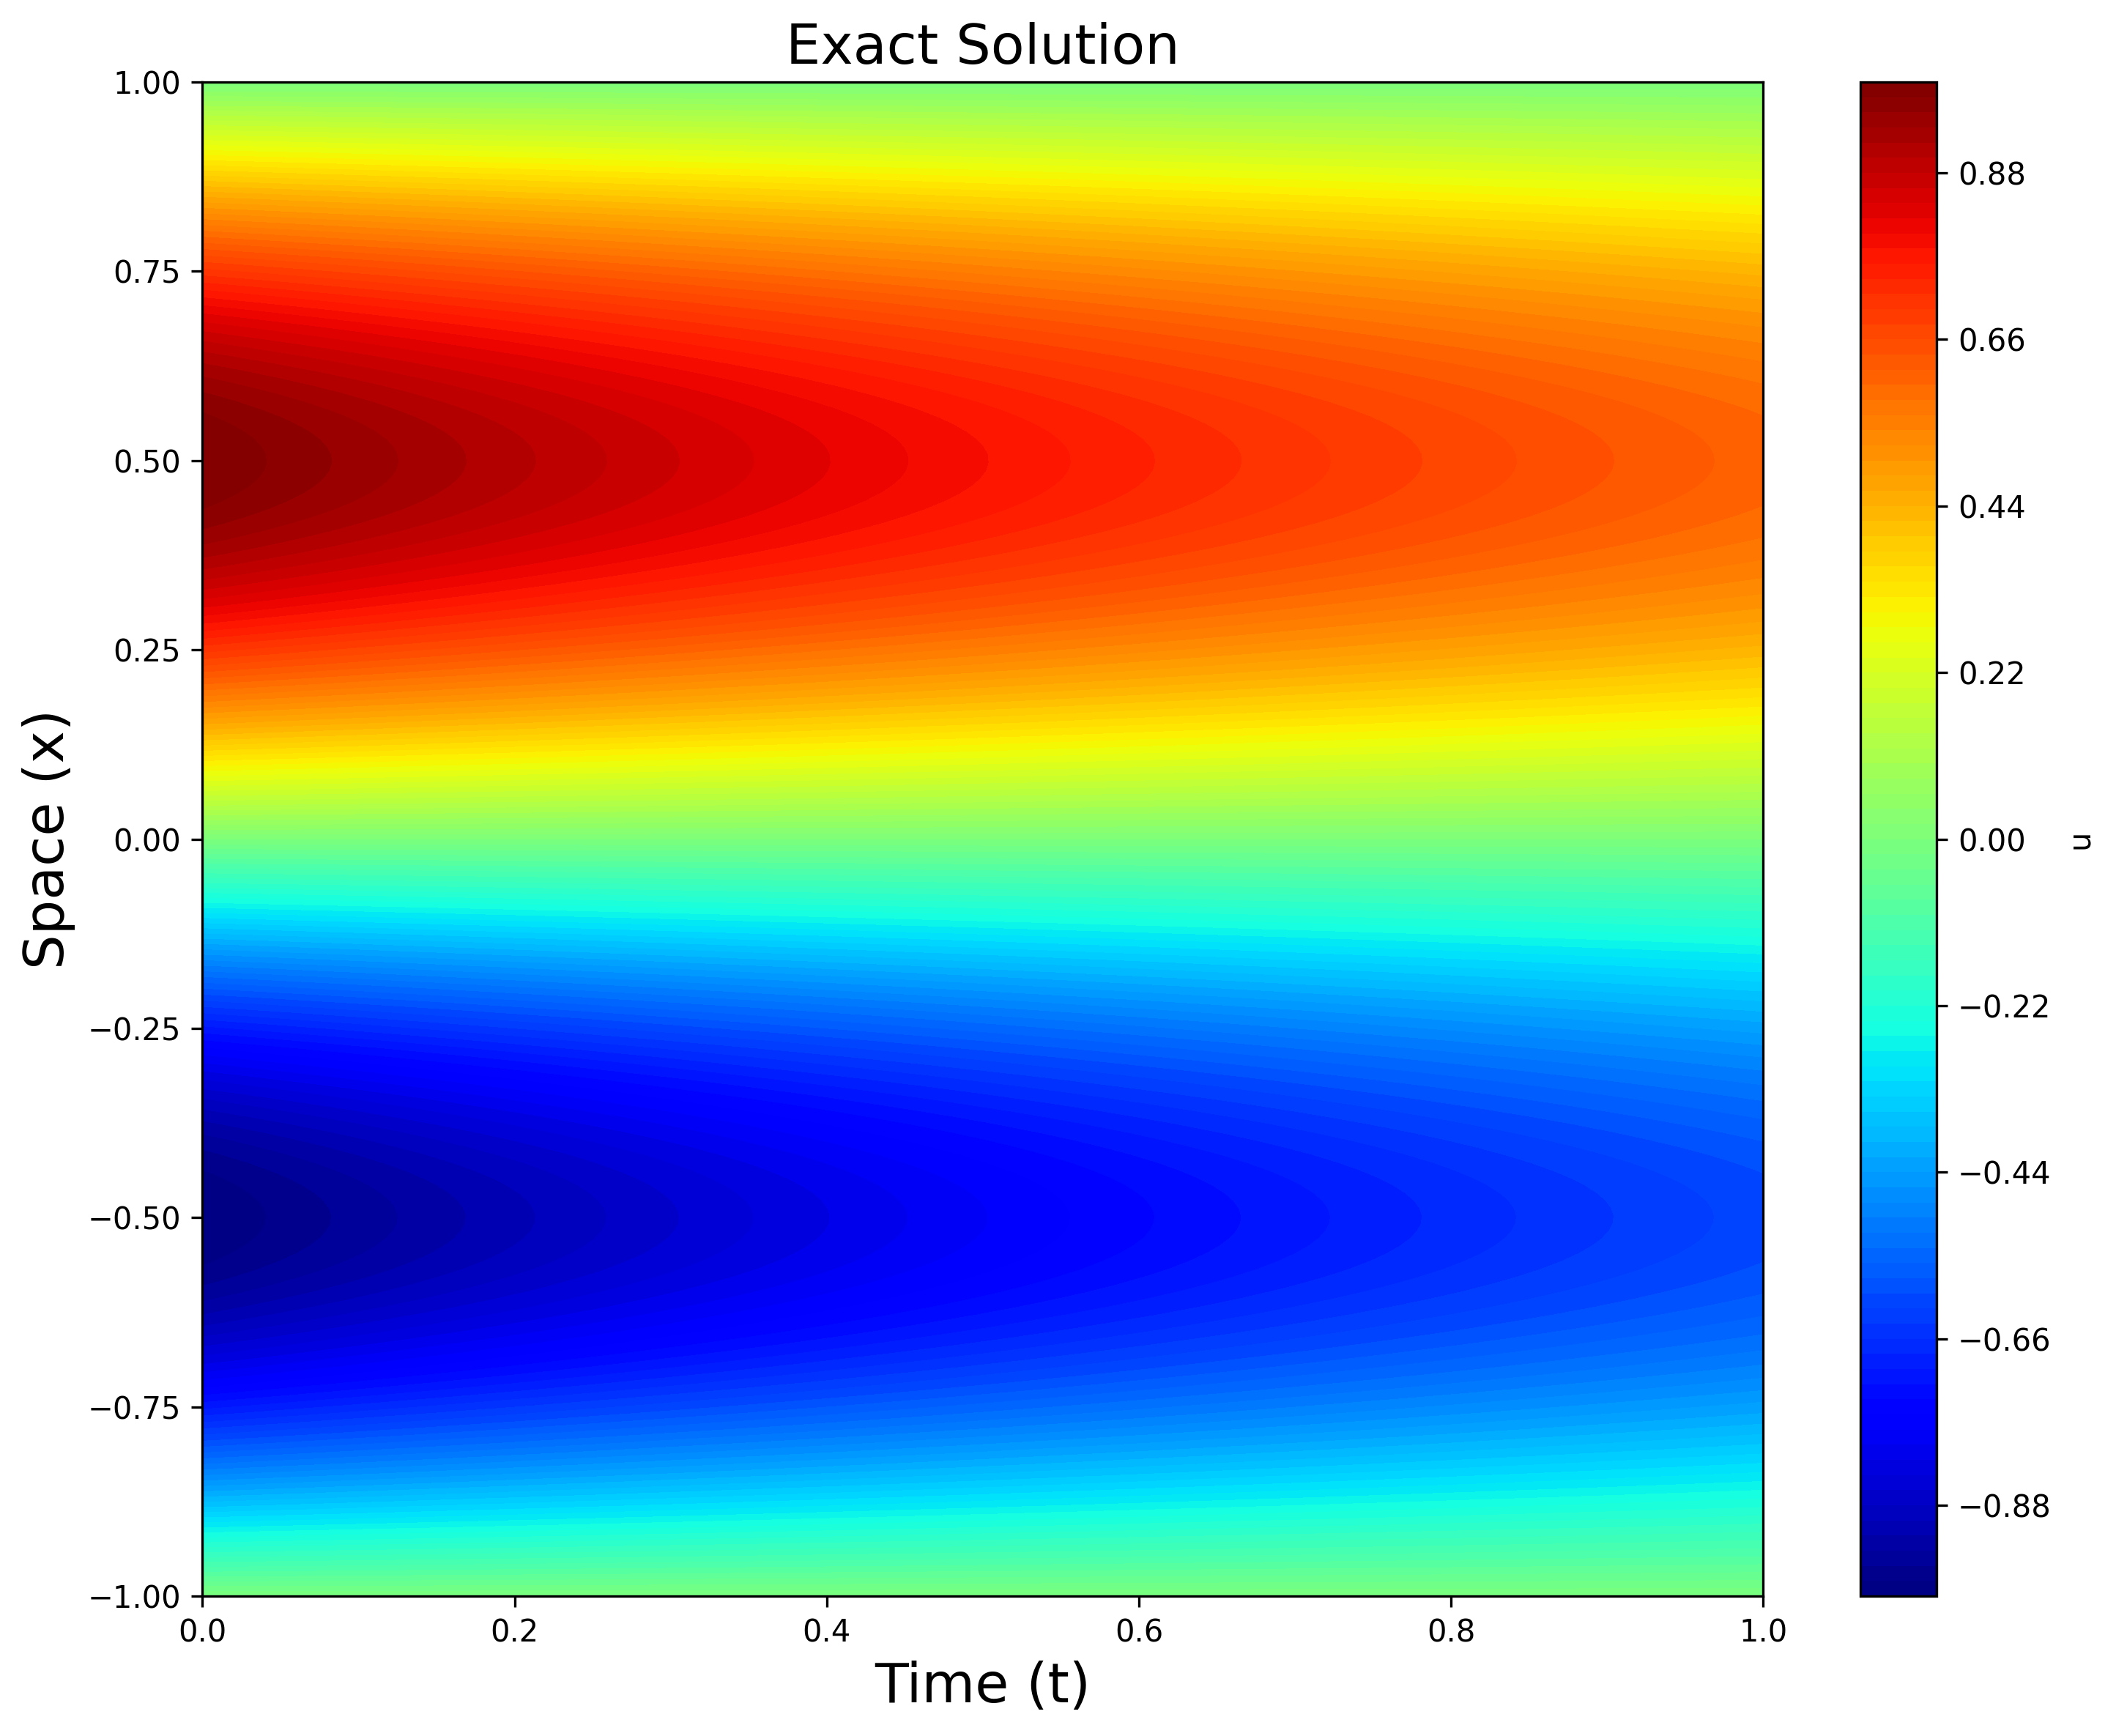

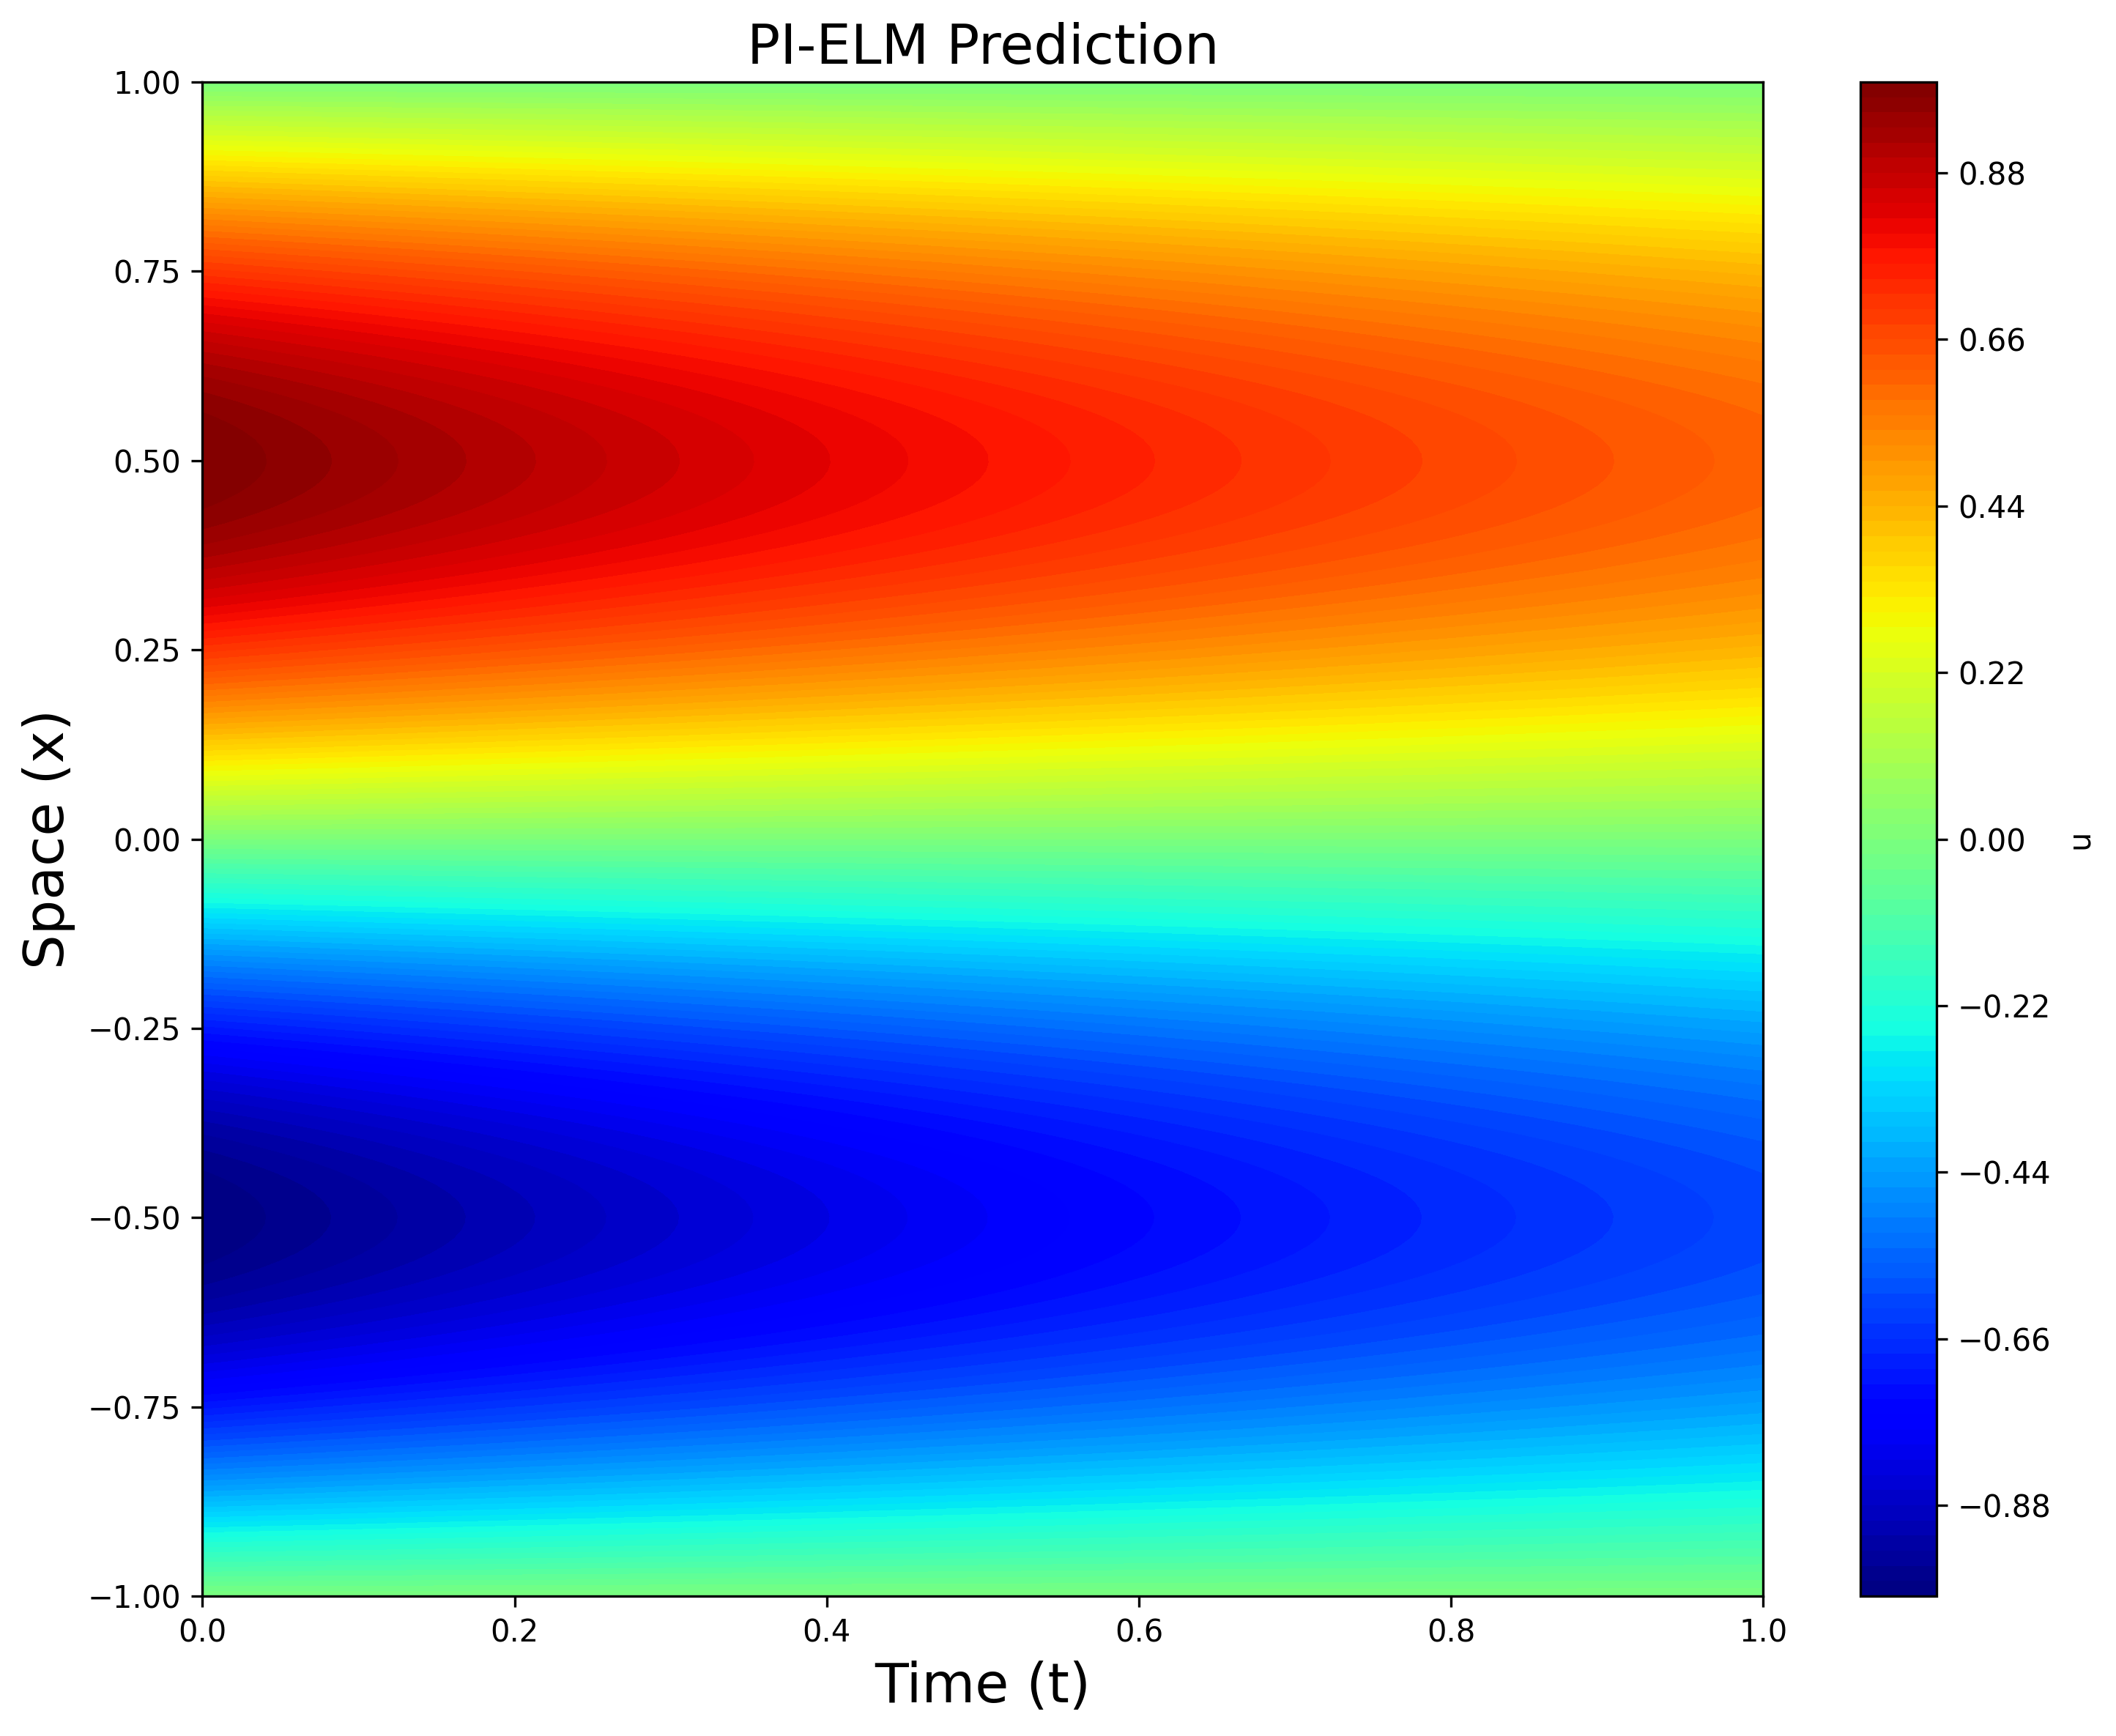

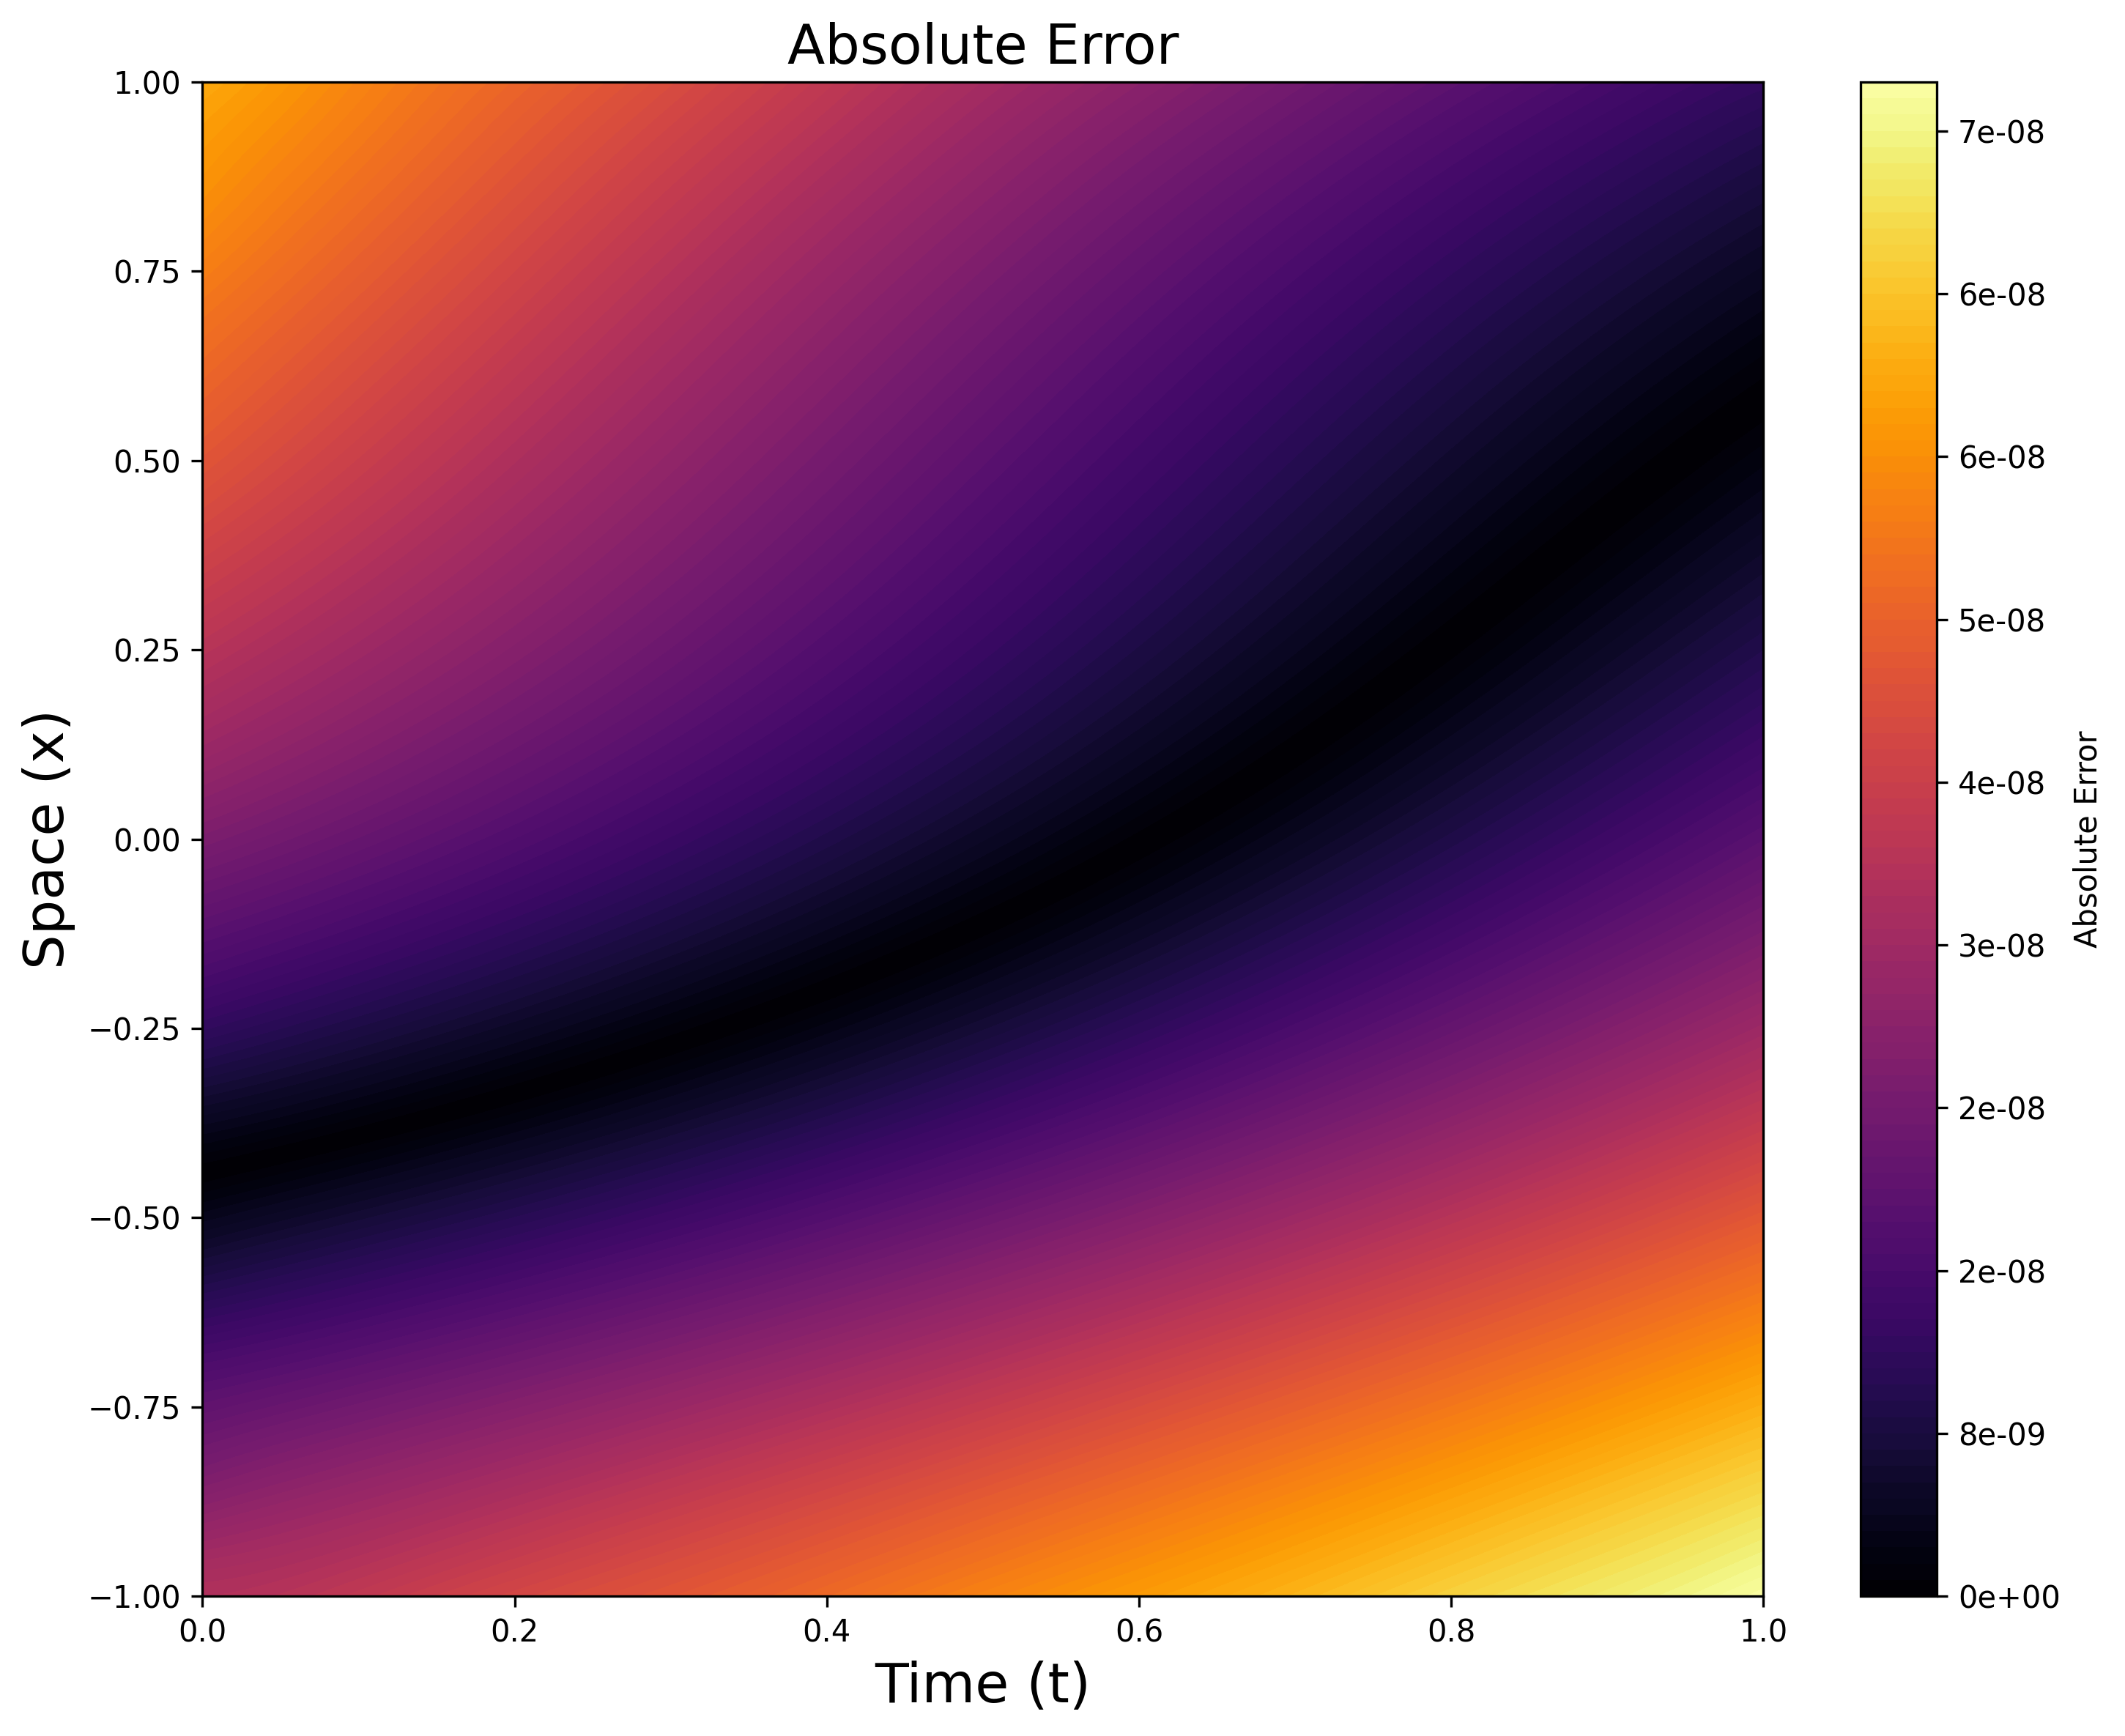

Max Absolute Error: 7.40618e-08


In [ ]:
# ==========================================
# 4. Visualization
# ==========================================
# Create grid for plotting
x_plot = np.linspace(-1, 1, 200)
t_plot = np.linspace(0, 1, 200)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)

X_flat = X_grid.flatten()[:, None]
T_flat = T_grid.flatten()[:, None]

# Compute solutions
u_pred = model.predict(X_flat, T_flat).reshape(X_grid.shape)
u_true = exact_solution(X_grid, T_grid, alpha)
abs_error = np.abs(u_true - u_pred)

# Plotting
# Plot 1: Exact Solution
plt.figure(figsize=(10, 8), dpi = 300)
im1 = plt.contourf(T_grid, X_grid, u_true, levels=100, cmap='jet')
plt.title('Exact Solution', fontsize=18)
plt.xlabel('Time (t)', fontsize=18)
plt.ylabel('Space (x)', fontsize=18)
plt.colorbar(im1, label='u')
plt.tight_layout()
plt.show()

# Plot 2: Predicted Solution
plt.figure(figsize=(10, 8), dpi = 300)
im2 = plt.contourf(T_grid, X_grid, u_pred, levels=100, cmap='jet')
plt.title('PI-ELM Prediction', fontsize=18)
plt.xlabel('Time (t)', fontsize=18)
plt.ylabel('Space (x)', fontsize=18)
plt.colorbar(im2, label='u')
plt.tight_layout()
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 8), dpi = 300)
im3 = plt.contourf(T_grid, X_grid, abs_error, levels=100, cmap='inferno')
plt.title('Absolute Error', fontsize=18)
plt.xlabel('Time (t)', fontsize=18)
plt.ylabel('Space (x)', fontsize=18)
plt.colorbar(im3, format='%.0e', label='Absolute Error') # Scientific notation for error
plt.tight_layout()
plt.show()

# Print Max Error
print(f"Max Absolute Error: {np.max(abs_error):.5e}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv

class PI_ELM_Laplace:
    def __init__(self, n_neurons):
        self.N = n_neurons

        # Random weights for x and y
        self.w_x = np.random.uniform(-1, 1, (self.N, 1))
        self.w_y = np.random.uniform(-1, 1, (self.N, 1))
        self.b = np.random.uniform(-1, 1, (self.N, 1))

        self.beta = None

    def activation(self, Z, order=0):
        # Using Tanh and its derivatives
        if order == 0:
            return np.tanh(Z)
        elif order == 2: # Second derivative: -2*tanh*(1-tanh^2)
            return -2 * np.tanh(Z) * (1 - np.tanh(Z)**2)
        return np.tanh(Z)

    def build_matrix(self, x, y, type='pde'):
        # Z = w_x*x + w_y*y + b
        Z = self.w_x @ x.T + self.w_y @ y.T + self.b

        if type == 'pde':
            # Laplacian: u_xx + u_yy = 0
            # d2/dx2 term
            dxx = self.activation(Z, order=2).T * (self.w_x**2).T
            # d2/dy2 term
            dyy = self.activation(Z, order=2).T * (self.w_y**2).T

            return dxx + dyy

        elif type == 'boundary':
            return self.activation(Z, order=0).T

    def train(self, X_f, Y_f, X_b, Y_b, U_b):
        print("Building matrices...")

        # 1. PDE Matrix (Target = 0)
        H_f = self.build_matrix(X_f, Y_f, type='pde')
        T_f = np.zeros((X_f.shape[0], 1))

        # 2. Boundary Matrix
        H_b = self.build_matrix(X_b, Y_b, type='boundary')
        T_b = U_b

        # 3. Stack Global System
        # Weighting boundaries higher (multiply by 10) improves accuracy for elliptic problems
        H_global = np.vstack([H_b * 10, H_f])
        T_global = np.vstack([T_b * 10, T_f])

        print(f"Solving Linear System ({H_global.shape})...")
        self.beta = pinv(H_global) @ T_global
        print("Training complete.")

    def predict(self, x, y):
        Z = self.w_x @ x.T + self.w_y @ y.T + self.b
        return self.activation(Z, order=0).T @ self.beta

# ==========================================
# Main Execution
# ==========================================

# 1. Collocation Points (Interior)
N_f = 2000
x_f = np.random.uniform(0, 1, (N_f, 1))
y_f = np.random.uniform(0, 1, (N_f, 1))

# 2. Boundary Points
N_b = 100 # per edge
# Bottom: y=0, u=sin(pi*x)
x_b1 = np.random.uniform(0, 1, (N_b, 1)); y_b1 = np.zeros((N_b, 1))
u_b1 = np.sin(np.pi * x_b1)

# Top: y=1, u=sin(pi*x)*e^-pi
x_b2 = np.random.uniform(0, 1, (N_b, 1)); y_b2 = np.ones((N_b, 1))
u_b2 = np.sin(np.pi * x_b2) * np.exp(-np.pi)

# Left: x=0, u=0
x_b3 = np.zeros((N_b, 1)); y_b3 = np.random.uniform(0, 1, (N_b, 1))
u_b3 = np.zeros((N_b, 1))

# Right: x=1, u=0
x_b4 = np.ones((N_b, 1)); y_b4 = np.random.uniform(0, 1, (N_b, 1))
u_b4 = np.zeros((N_b, 1))

# Combine Boundaries
X_b = np.vstack([x_b1, x_b2, x_b3, x_b4])
Y_b = np.vstack([y_b1, y_b2, y_b3, y_b4])
U_b = np.vstack([u_b1, u_b2, u_b3, u_b4])

# 3. Train
model = PI_ELM_Laplace(n_neurons=200)
model.train(x_f, y_f, X_b, Y_b, U_b)

Building matrices...
Solving Linear System ((2400, 200))...
Training complete.


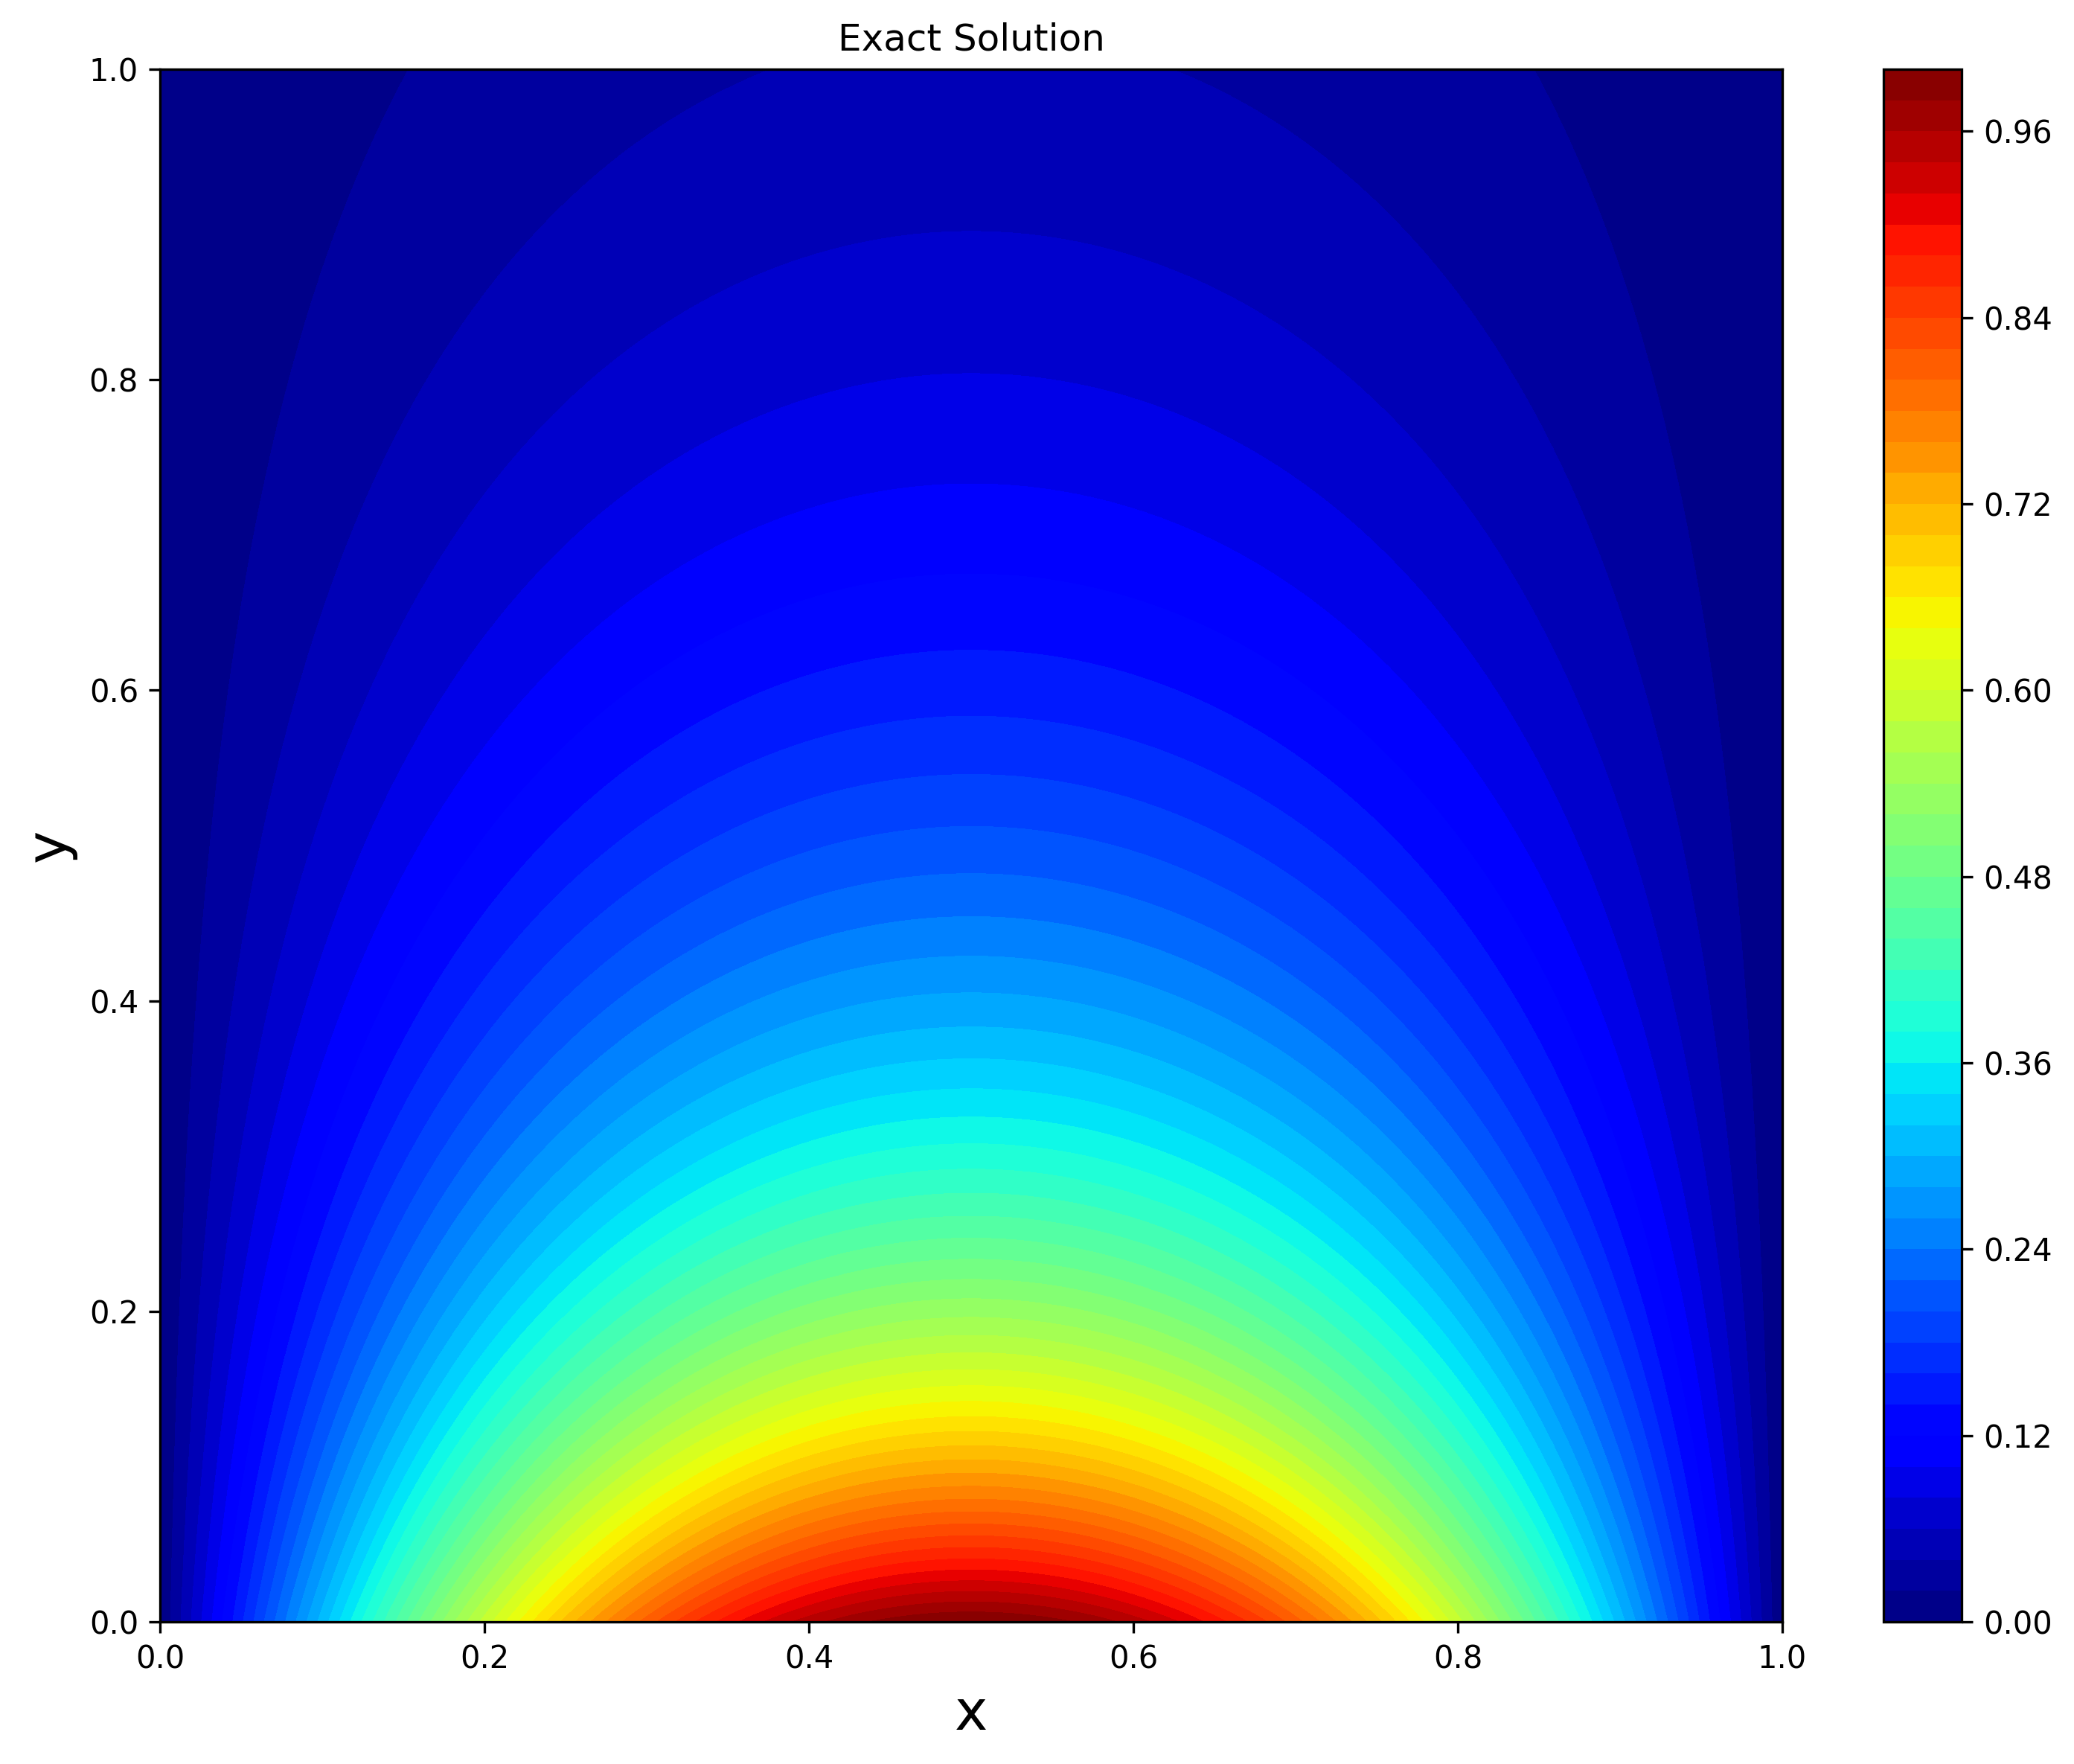

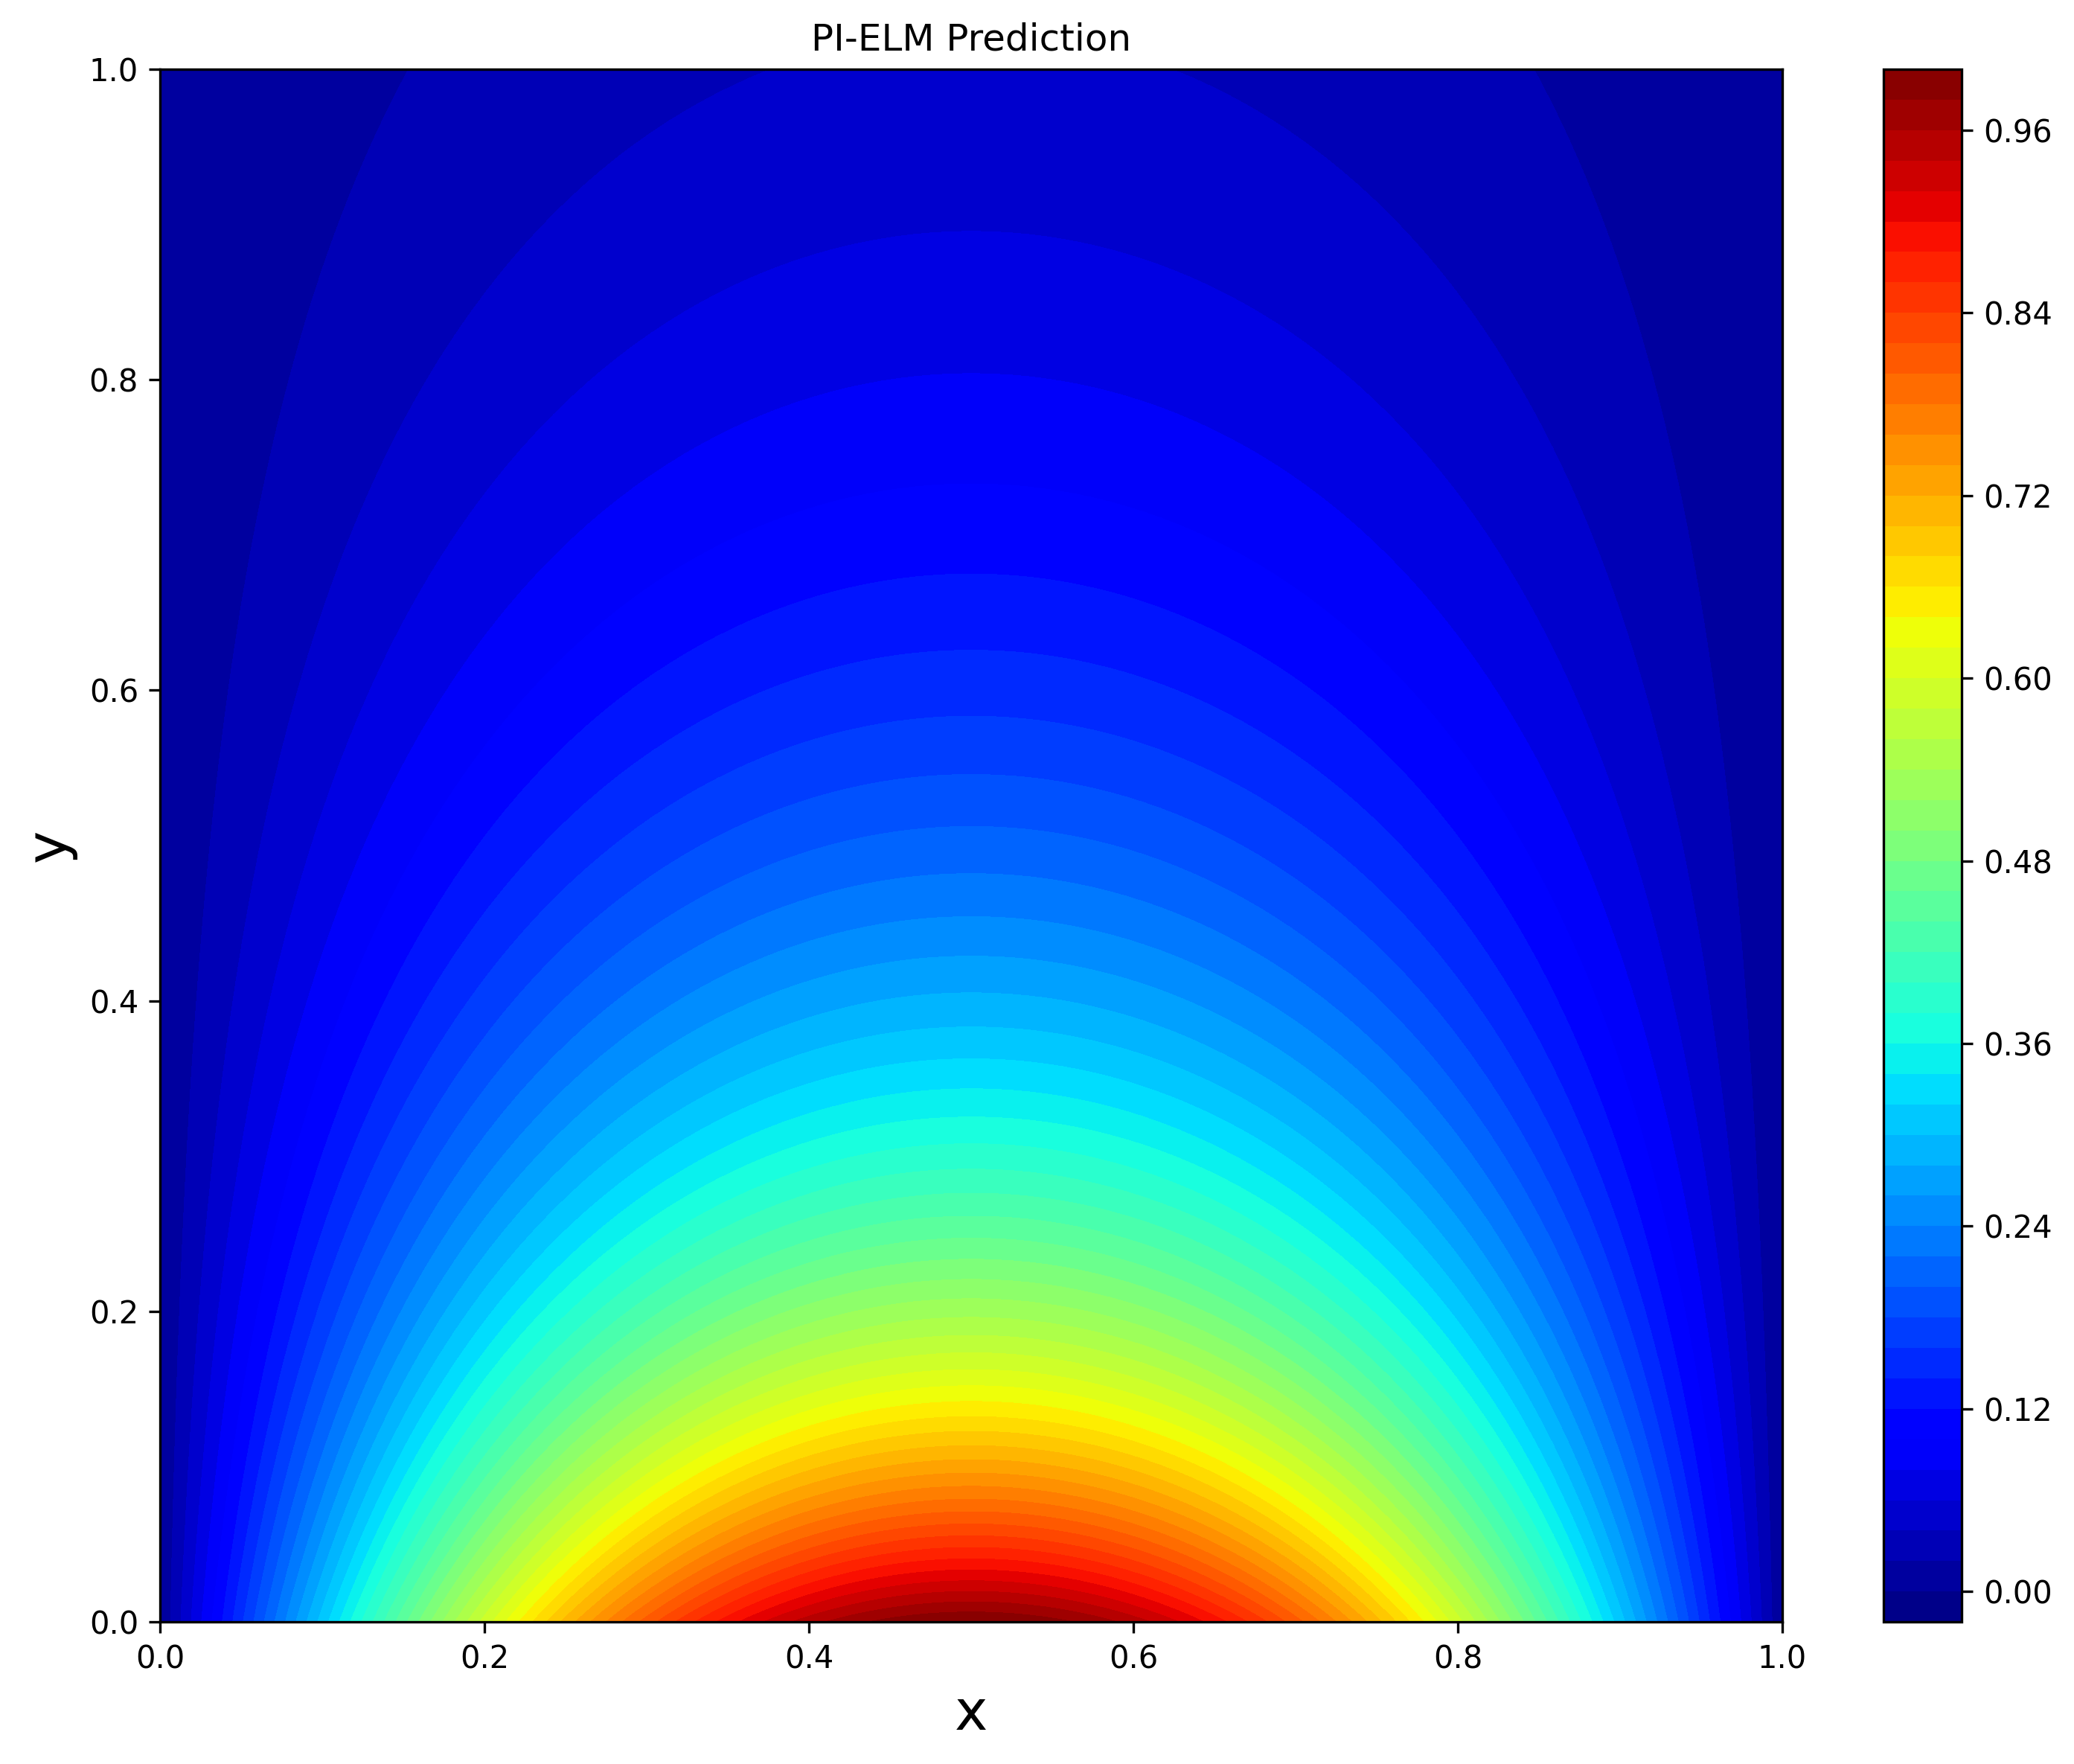

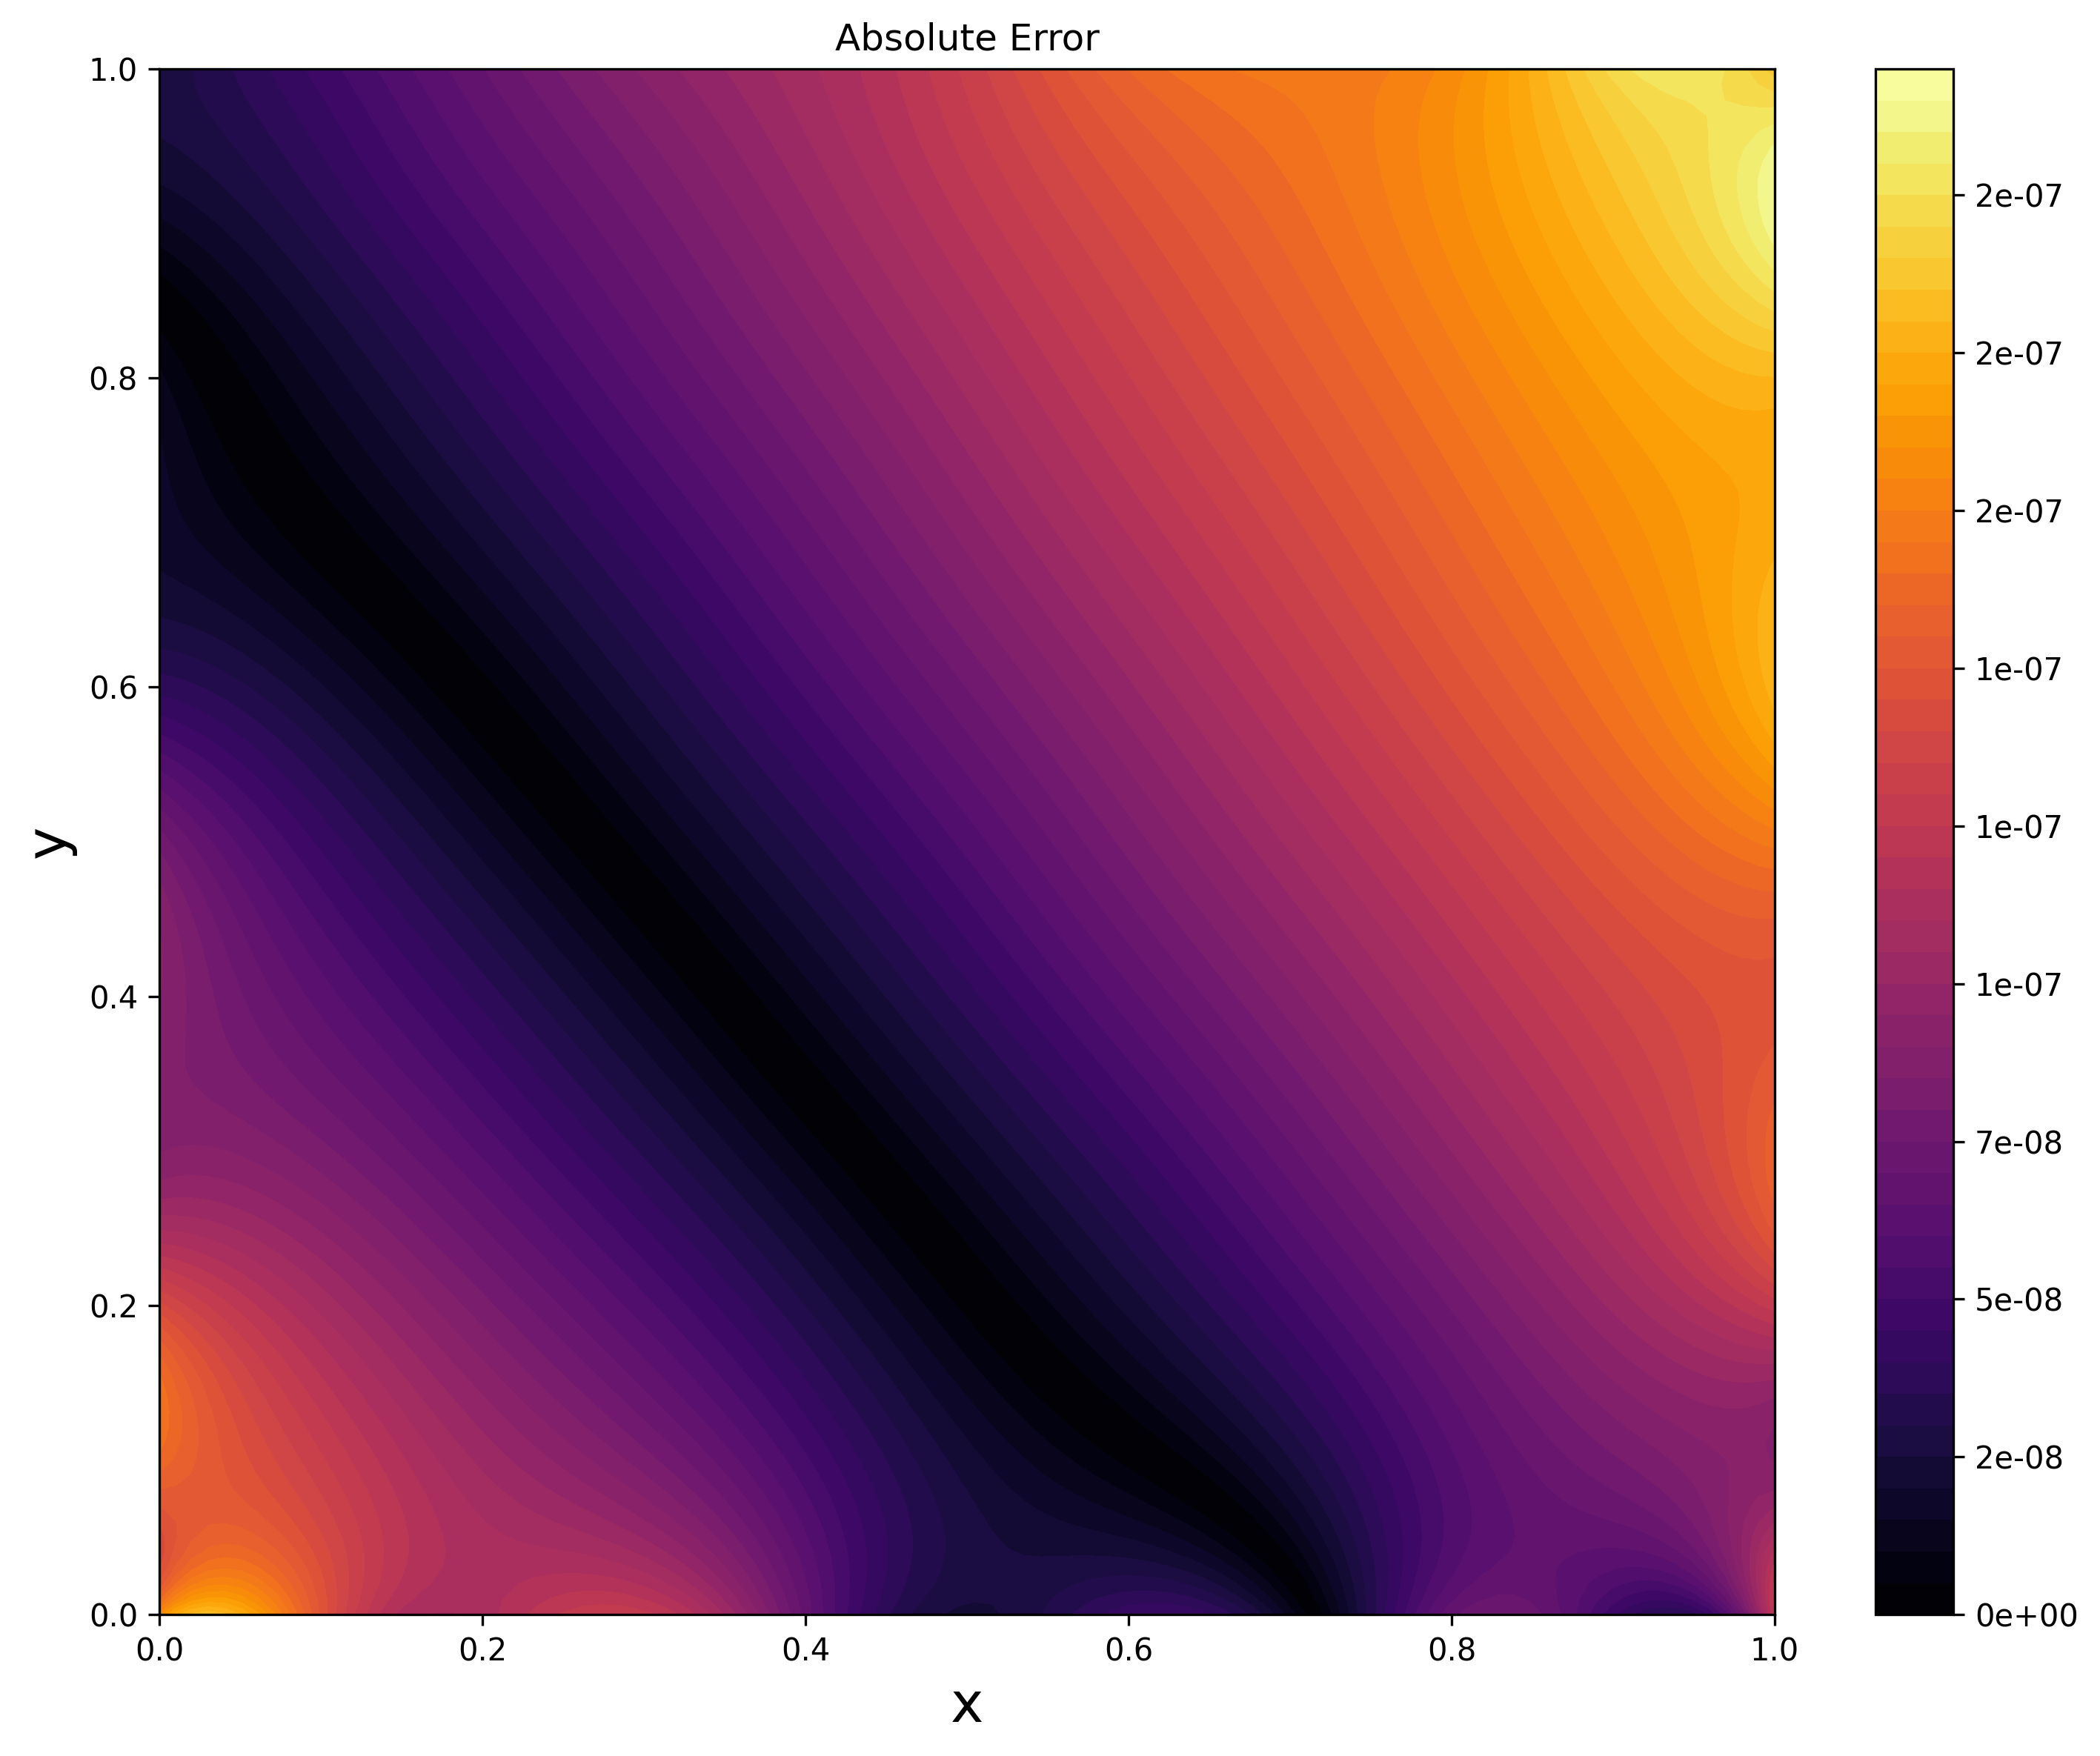

Max Absolute Error: 2.40164e-07


In [ ]:
# 4. Visualization & Error Analysis
x_plot = np.linspace(0, 1, 100)
y_plot = np.linspace(0, 1, 100)
X_grid, Y_grid = np.meshgrid(x_plot, y_plot)

X_flat = X_grid.flatten()[:, None]
Y_flat = Y_grid.flatten()[:, None]

# Exact Solution
u_exact = np.sin(np.pi * X_grid) * np.exp(-np.pi * Y_grid)

# Predicted Solution
u_pred = model.predict(X_flat, Y_flat).reshape(X_grid.shape)
abs_error = np.abs(u_exact - u_pred)

# Plotting

# Plot 1: Exact Solution
plt.figure(figsize=(10, 8), dpi = 300)
im1 = plt.contourf(X_grid, Y_grid, u_exact, levels=50, cmap='jet')
plt.title('Exact Solution')
plt.xlabel('x', fontsize = 18); plt.ylabel('y', fontsize = 18)
plt.colorbar(im1)
plt.tight_layout()
plt.show()

# Plot 2: Predicted Solution
plt.figure(figsize=(10, 8), dpi = 300)
im2 = plt.contourf(X_grid, Y_grid, u_pred, levels=50, cmap='jet')
plt.title('PI-ELM Prediction')
plt.xlabel('x', fontsize = 18); plt.ylabel('y', fontsize = 18)
plt.colorbar(im2)
plt.tight_layout()
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 8), dpi = 300)
im3 = plt.contourf(X_grid, Y_grid, abs_error, levels=50, cmap='inferno')
plt.title('Absolute Error')
plt.xlabel('x', fontsize = 18); plt.ylabel('y', fontsize = 18)
plt.colorbar(im3, format='%.0e')
plt.tight_layout()
plt.show()

print(f"Max Absolute Error: {np.max(abs_error):.5e}")